In [25]:

polygon_points = [
    (0.5, 0.1), 
    (1.5, 0.2), 
    (1.0, 0.4)
    ]

In [26]:
import gmsh

# Initialize Gmsh
gmsh.initialize(["", "-bin"])
# gmsh.option.set("General.Terminal", 1)  # Uncomment to see output in terminal

# Step 1: Define the Geometry
gmsh.model.add("WindChannel")
mesh_size = 0.02

channel_length = 2.0
channel_height = 0.5
# Define Points (Corner Points of the Rectangle - Wind Channel)
p1 = gmsh.model.geo.addPoint(0.0, 0.0, 0.0, mesh_size)
p2 = gmsh.model.geo.addPoint(channel_length, 0.0, 0.0, mesh_size)
p3 = gmsh.model.geo.addPoint(channel_length, channel_height, 0.0, mesh_size)
p4 = gmsh.model.geo.addPoint(0.0, channel_height, 0.0, mesh_size)

polygon_points = [(0.5, 0.1), (1.5, 0.2), (1.0, 0.4)]
# Define the Polygon (Triangular Polygon inside the channel)
# p5 = gmsh.model.geo.addPoint(0.5, 0.1, 0.0, mesh_size)
# p6 = gmsh.model.geo.addPoint(1.5, 0.1, 0.0, mesh_size)
# p7 = gmsh.model.geo.addPoint(1.0, 0.4, 0.0, mesh_size)
polygon_gmsh_points = [gmsh.model.geo.addPoint(x, y, 0.0, mesh_size) for x, y in polygon_points]

# Define Lines for the Wind Channel
l1 = gmsh.model.geo.addLine(p1, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p4)
l4 = gmsh.model.geo.addLine(p4, p1)

# # Define Lines for the Polygon (Triangle)
# l5 = gmsh.model.geo.addLine(p5, p6)
# l6 = gmsh.model.geo.addLine(p6, p7)
# l7 = gmsh.model.geo.addLine(p7, p5)
polygon_lines = [gmsh.model.geo.addLine(polygon_gmsh_points[i], polygon_gmsh_points[(i+1)%len(polygon_gmsh_points)]) for i in range(len(polygon_gmsh_points))]

# Define Surface Loops
ll1 = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])  # Loop for the outer rectangle (wind channel)
ll2 = gmsh.model.geo.addCurveLoop(polygon_lines)      # Loop for the inner triangle (polygon)

# Define Plane Surfaces
s1 = gmsh.model.geo.addPlaneSurface([ll1, ll2])  # Surface for the wind channel with the polygon inside

# Step 2: Define the Mesh
# Synchronize to prepare for mesh generation
gmsh.model.geo.synchronize()

# Step 3: Mesh Generation
# Generate 2D mesh
gmsh.model.mesh.generate(2)

# Save the mesh to a binary file
gmsh.write("wind_channel.vtk")

# Finalize Gmsh
gmsh.finalize()

import pyvista as pv
import numpy as np

grid=pv.read("wind_channel.vtk")
points = grid.points
num_points = grid.number_of_points

grid.point_data["marker"]=np.zeros(num_points)

# set marker to 1 at inlet and outlet
grid.point_data["marker"][points[:,0]==0.0]=1
grid.point_data["marker"][points[:,0]==channel_length]=1


# set marker to 4 at all walls

# top and bottom walls
grid.point_data["marker"][points[:,1]==0.0]=4
grid.point_data["marker"][points[:,1]==channel_height]=4

# polygon walls

# find the points that are inside the polygon

from shapely.geometry import Polygon, Point
polygon = Polygon(polygon_points)
tolerance=1e-3
on_polygon = [polygon.dwithin(Point(x, y),tolerance) for x, y in points[:,:2]]
grid.point_data["marker"][on_polygon]=4

# for i in range(num_points):
#     p1 = (points[i,0], points[i,1])
#     j=(i+1)%num_points
#     p2 = (points[j,0], points[j,1])
#     points_on_lines = points
# polygon = Polygon(polygon_points)

for target in ["p","u","v"]:
    grid.point_data[target]=np.zeros(num_points)



grid.save("wind_channel.vtk")

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Line)
Info    : [ 80%] Meshing curve 6 (Line)
Info    : [ 90%] Meshing curve 7 (Line)
Info    : Done meshing 1D (Wall 0.00325937s, CPU 0.000307s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0494371s, CPU 0.043763s)
Info    : 2798 nodes 5603 elements
Info    : Writing 'wind_channel.vtk'...
Info    : Done writing 'wind_channel.vtk'


/opt/homebrew/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


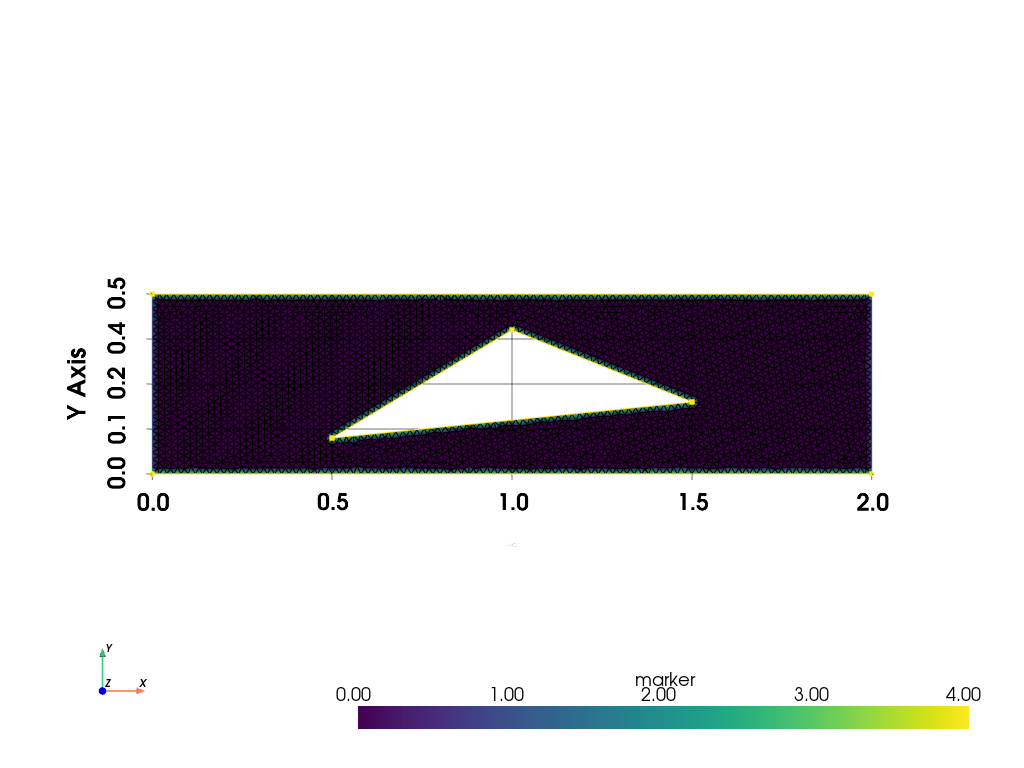

In [27]:
grid.plot(scalars="marker", show_edges=True, show_grid=True, notebook=True, cpos="xy")

In [42]:
grid.surface_indices()

pyvista_ndarray([   0,    1,    2, ..., 2713, 2785, 2784])

/opt/homebrew/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


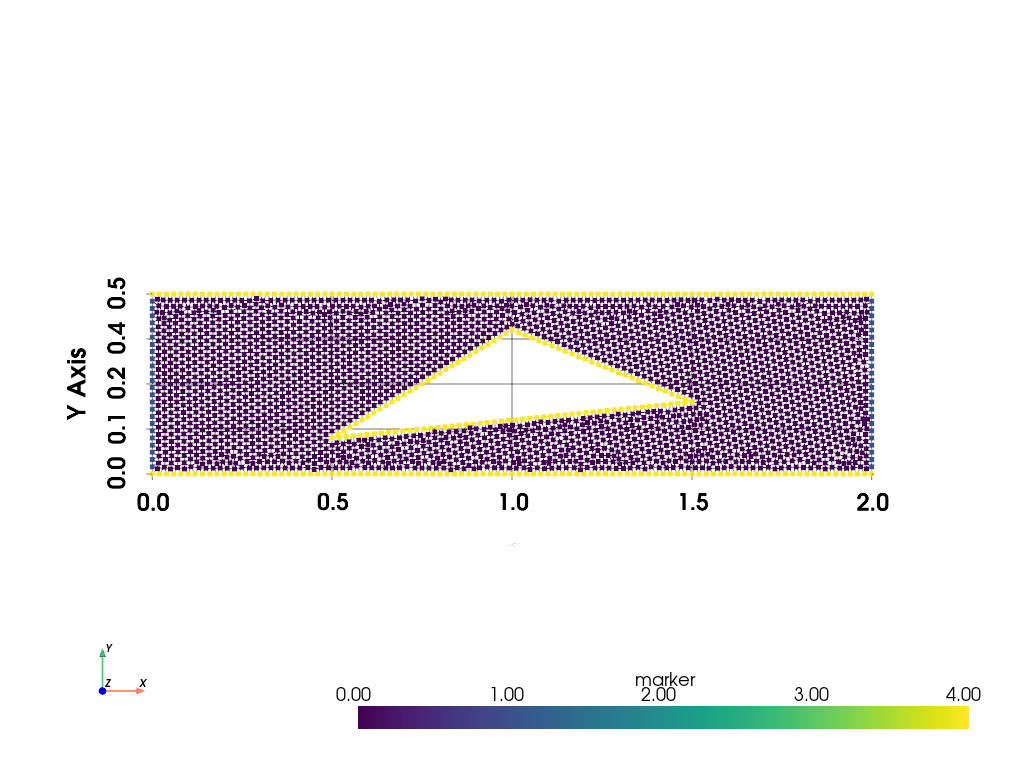

In [38]:
poly_grid = pv.PolyData(grid.points)
poly_grid.lines = grid.cells
poly_grid.point_data["marker"] = grid.point_data["marker"]
poly_grid.point_data["p"] = grid.point_data["p"]
poly_grid.point_data["u"] = grid.point_data["u"]
poly_grid.point_data["v"] = grid.point_data["v"]


poly_grid.plot(scalars="marker",show_edges=True, show_grid=True, notebook=True, cpos="xy")
poly_grid.save("wind_channel.vtp")